# DiscreteDP Example: Mine Management

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

From Miranda and Fackler, <i>Applied Computational Economics and Finance</i>, 2002,
Section 7.6.1

In [1]:
%matplotlib inline

In [2]:
import itertools
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

The model is formulated with finite horizon in Section 7.2.1,
but solved with infinite horizon in Section 7.6.1.
Here we follow the latter.

In [3]:
price = 1     # Market price of ore
sbar = 100    # Upper bound of ore stock
beta = 0.9    # Discount rate
n = sbar + 1  # Number of states
m = sbar + 1  # Number of actions

# Cost function
c = lambda s, x: x**2 / (1+s)

## Product formulation

This approch sets up the reward array `R` and the transition probability array `Q`
as a 2-dimensional array of shape `(n, m)`
and a 3-simensional array of shape `(n, m, n)`, respectively,
where the reward is set to $-\infty$ for infeasible state-action pairs
(and the transition probability distribution is arbitrary for those pairs).

Reward array:

In [4]:
R = np.empty((n, m))
for s, x in itertools.product(range(n), range(m)):
    R[s, x] = price * x - c(s, x) if x <= s else -np.inf

(Degenerate) transition probability array:

In [5]:
Q = np.zeros((n, m, n))
for s, x in itertools.product(range(n), range(m)):
    if x <= s:
        Q[s, x, s-x] = 1
    else:
        Q[s, x, 0] = 1  # Arbitrary

Set up the dynamic program as a `DiscreteDP` instance:

In [6]:
ddp = DiscreteDP(R, Q, beta)

Solve the optimization problem with the `solve` method,
which by defalut uses the policy iteration algorithm:

In [7]:
res = ddp.solve()

The number of iterations:

In [8]:
res.num_iter

9

The controlled Markov chain is stored in `res.mc`.
To simulate:

In [9]:
nyrs = 15
spath = res.mc.simulate(nyrs+1, init=sbar)

In [10]:
spath

array([100,  76,  58,  44,  33,  25,  19,  14,  11,   8,   6,   4,   3,
         2,   1,   0])

Draw the graphs:

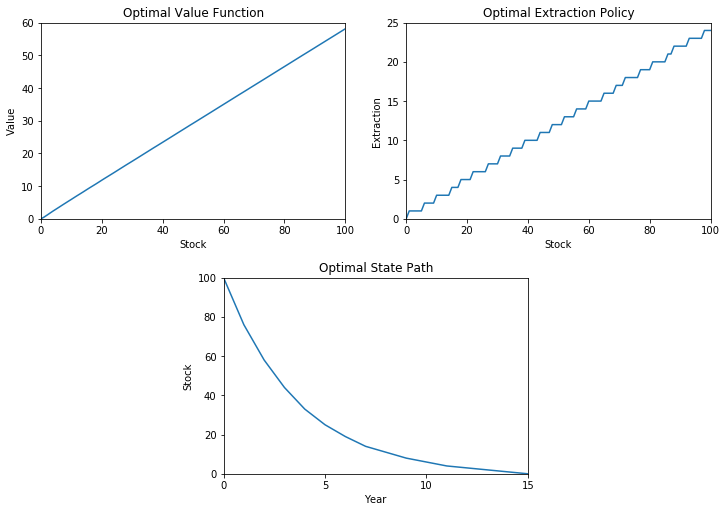

In [11]:
wspace = 0.5
hspace = 0.3
fig = plt.figure(figsize=(12, 8+hspace))
fig.subplots_adjust(wspace=wspace, hspace=hspace)
ax0 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax2 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

ax0.plot(res.v)
ax0.set_xlim(0, sbar)
ax0.set_ylim(0, 60)
ax0.set_xlabel('Stock')
ax0.set_ylabel('Value')
ax0.set_title('Optimal Value Function')

ax1.plot(res.sigma)
ax1.set_xlim(0, sbar)
ax1.set_ylim(0, 25)
ax1.set_xlabel('Stock')
ax1.set_ylabel('Extraction')
ax1.set_title('Optimal Extraction Policy')

ax2.plot(spath)
ax2.set_xlim(0, nyrs)
ax2.set_ylim(0, sbar)
ax2.set_xticks(np.linspace(0, 15, 4, endpoint=True))
ax2.set_xlabel('Year')
ax2.set_ylabel('Stock')
ax2.set_title('Optimal State Path')

plt.show()

## State-action pairs formulation

This approach assigns the rewards and transition probabilities
only to feaslbe state-action pairs,
setting up `R` and `Q` as a 1-dimensional array of length `L`
and a 2-dimensional array of shape `(L, n)`, respectively.
In particular, this allows us to formulate `Q` in
[scipy sparse matrix format](http://docs.scipy.org/doc/scipy/reference/sparse.html).

We need the arrays of feasible state and action indices:

In [12]:
S = np.arange(n)
X = np.arange(m)

# Values of remaining stock in the next period
S_next = S.reshape(n, 1) - X.reshape(1, m)

# Arrays of feasible state and action indices
s_indices, a_indices = np.where(S_next >= 0)

# Number of feasible state-action pairs
L = len(s_indices)

In [13]:
L

5151

In [14]:
s_indices

array([  0,   1,   1, ..., 100, 100, 100])

In [15]:
a_indices

array([  0,   0,   1, ...,  98,  99, 100])

Reward vector:

In [16]:
R = np.empty(L)
for i, (s, x) in enumerate(zip(s_indices, a_indices)):
    R[i] = price * x - c(s, x)

(Degenerate) transition probability array,
where we use the [scipy.sparse.lil_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) format,
while any format will do
(internally it will be converted to the [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format):

In [17]:
Q = sparse.lil_matrix((L, n))
it = np.nditer((s_indices, a_indices), flags=['c_index'])
for s, x in it:
    i = it.index
    Q[i, s-x] = 1

Alternatively, one can construct `Q` directly as a scipy.sparse.csr_matrix as follows: 

In [18]:
# data = np.ones(L)
# indices = s_indices - a_indices
# indptr = np.arange(L+1)
# Q = sparse.csr_matrix((data, indices, indptr), shape=(L, n))

Set up the dynamic program as a `DiscreteDP` instance:

In [19]:
ddp_sp = DiscreteDP(R, Q, beta, s_indices, a_indices)

Solve the optimization problem with the `solve` method,
which by defalut uses the policy iteration algorithm:

In [20]:
res_sp = ddp_sp.solve()

Number of iterations:

In [21]:
res_sp.num_iter

9

Simulate the controlled Markov chain:

In [22]:
nyrs = 15
spath_sp = res_sp.mc.simulate(nyrs+1, init=sbar)

Draw the graphs:

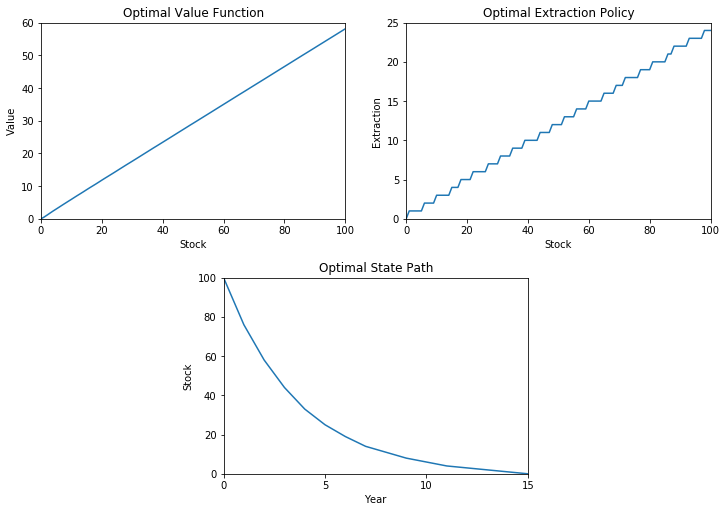

In [23]:
wspace = 0.5
hspace = 0.3
fig = plt.figure(figsize=(12, 8+hspace))
fig.subplots_adjust(wspace=wspace, hspace=hspace)
ax0 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax2 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

ax0.plot(res_sp.v)
ax0.set_xlim(0, sbar)
ax0.set_ylim(0, 60)
ax0.set_xlabel('Stock')
ax0.set_ylabel('Value')
ax0.set_title('Optimal Value Function')

ax1.plot(res_sp.sigma)
ax1.set_xlim(0, sbar)
ax1.set_ylim(0, 25)
ax1.set_xlabel('Stock')
ax1.set_ylabel('Extraction')
ax1.set_title('Optimal Extraction Policy')

ax2.plot(spath_sp)
ax2.set_xlim(0, nyrs)
ax2.set_ylim(0, sbar)
ax2.set_xticks(np.linspace(0, 15, 4, endpoint=True))
ax2.set_xlabel('Year')
ax2.set_ylabel('Stock')
ax2.set_title('Optimal State Path')

plt.show()